In [112]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
#Ignore warnings
import warnings
import scipy
from datetime import datetime
from platform import python_version
import statsmodels.api as sm
import matplotlib.dates as mdates
print(python_version())
warnings.filterwarnings('ignore')

3.9.7


In [ ]:
df = pd.read_csv('C:\\Users\\20203666\\Documents\\JBG050-data\\final_burglary_data_city1.csv')
df['year month'] = [datetime.strptime(date, '%Y-%m') for date in df['year month']]
print(sorted(df['city'].unique()))

WARNING!
Time Series is non-stationary, taking the first difference 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=739.565, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=703.713, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=737.611, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=727.059, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=699.416, Time=0.78 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=700.787, Time=1.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=714.209, Time=0.25 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=701.220, Time=0.52 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=700.112, Time=0.62 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=698.243, Time=0.34 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AI

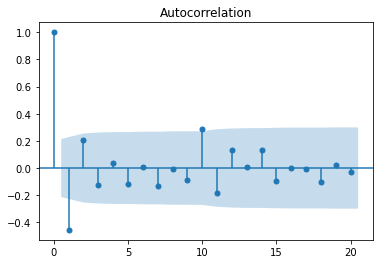

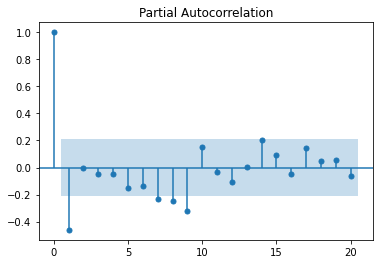

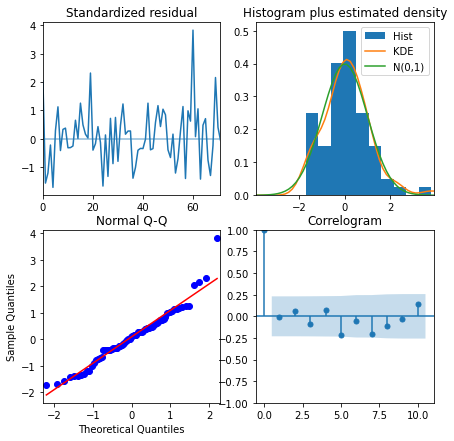

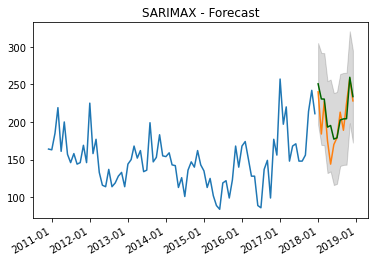

In [135]:
col = 'burglarys city'
n_periods = 12
city = 'Solihull'

df_city = df.loc[df['city'] == city]
# Reset index to stop expected value error

df_city_index_reset = df_city.reset_index(drop = True)

#Sort it on year/month to perform ARIMA
df_city_sorted = df_city_index_reset.set_index(df_city_index_reset['year month'])

df_city_train = df_city_sorted['2010-12':'2017-12']
adf = adfuller(df_city_train[col].dropna())

if adf[1] >0.05:
    df_city_sorted['diff burglarys city'] = df_city_sorted[col].diff()
    col= 'diff burglarys city'
    print('WARNING!\nTime Series is non-stationary, taking the first difference \n')

#Create test partition
df_city_train = df_city_sorted['2010-12':'2017-12']
df_city_test  = df_city_sorted['2018-1':'2019-12']

plot_acf(df_city_train[col].dropna())
plot_pacf(df_city_train[col].dropna())

smodel = auto_arima(df_city_train[col].dropna(), start_p=1, start_q=1,
                    test='adf',
                    max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True,
                    d=0, D=1, trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)
print(smodel.summary())

fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = df_city_test.index[:n_periods]

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

smodel.plot_diagnostics(figsize=(7, 7))
plt.show()
col = 'burglarys city'
if adf[1] > 0.05:
    for i in range(len(df_city_test[:n_periods])):
        if i == 0:
            y = df_city_train[col][-1]
        predicted_upper = y + upper_series[i]
        upper_series[i] = predicted_upper
        predicted_y = y + fitted_series[i]
        fitted_series[i] = predicted_y
        predicted_lower = y + lower_series[i]
        lower_series[i] = predicted_lower
        y=predicted_y

# Plot
plt.plot(df_city_train[col].dropna())
plt.plot(df_city_test[col][:n_periods].dropna())
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.title("SARIMAX - Forecast")
plt.show()

In [136]:
print('MAE:', mean_absolute_error(df_city_test[col][:n_periods].dropna(), fitted_series))
print("R2:", r2_score(df_city_test[col][:n_periods].dropna(), fitted_series))

MAE: 15.883359445614351
R2: 0.5181525773377684


In [137]:
all_adf = []
for city in sorted(df['city'].unique()):
    df_city = df.loc[df['city'] == city]
    # Reset index to stop expected value error

    df_city_index_reset = df_city.reset_index(drop = True)

    #Sort it on year/month to perform ARIMA
    df_city_sorted = df_city_index_reset.set_index(df_city_index_reset['year month'])

    #Create test partition
    df_city_train = df_city_sorted['2010-12':'2017-12']
    df_city_test  = df_city_sorted['2017-12':'2019-12']
    adf = adfuller(df_city_train[col].dropna())
    all_adf.append([adf[1], city])

In [129]:
count = 0
for p_value in all_adf:
    if p_value[0] > 0.05:
        print(p_value)
        count+=1
print(f'percentage of cities with a non-stationary time series: {(count/len(all_adf))*100}')

[0.12379602018514313, 'Amber Valley']
[0.8197394408901681, 'Barking and Dagenham']
[0.6690847719840085, 'Barnet']
[0.16416670590697602, 'Barnsley']
[0.3121104569507079, 'Birmingham']
[0.6118531835209174, 'Bolsover']
[0.37463663921148715, 'Bracknell Forest']
[0.28466287826409564, 'Bradford']
[0.761108449751251, 'Brent']
[0.3093753497543549, 'Bridgend']
[0.17750002482021277, 'Brighton and Hove']
[0.78900140503725, 'Bromley']
[0.8802255884924897, 'Bromsgrove']
[0.1714308836400229, 'Broxtowe']
[0.2710978008103583, 'Caerphilly']
[0.10586576036332707, 'Cambridge']
[0.09057953937425195, 'Cardiff']
[0.560231983025205, 'Castle Point']
[0.5592115643575387, 'Cherwell']
[0.3573064629831805, 'Cheshire West and Chester']
[0.30474988069151976, 'Chichester']
[0.3484844670132945, 'Chiltern']
[0.0655425402195777, 'Corby']
[0.6099586148989727, 'Cornwall']
[0.16892929410676188, 'Coventry']
[0.6121622687091509, 'Crawley']
[0.4786515087257871, 'Croydon']
[0.12146794734915523, 'Darlington']
[0.14266232967891